Acticipate Dataset

In [ ]:
from torch.utils.data import Dataset
import cv2
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
import h5py
import numpy as np


class ActicipateDataset(Dataset):

    def __init__(self, is_batch = True):

        self.is_batch = is_batch
        self.head_positions = np.load('/content/drive/My Drive/head_key_points.npy')
        self.body_positions = np.load('/content/drive/My Drive/body_key_points.npy')
        self.ball_positions = np.load('/content/drive/My Drive/ball_key_points.npy')
        self.frame_info = np.load('/content/drive/My Drive/frame_info.npy')
        self.data_labels = np.load("/content/drive/My Drive/action_labels.npy")[:,1]
        # change the label of action class 12 to 0 for compatibility with cross entropy loss 
        self.data_labels[self.data_labels == 12] = 0


    def __len__(self):
        return self.frame_info.shape[0]

    def __getitem__(self, id):
        first, last = int(self.frame_info[id][0]), int(self.frame_info[id][1])+1
        if self.is_batch == True:
            if last >= first + 100:
                last = first + 100
                return self.head_positions[first:last], self.body_positions[first:last], self.ball_positions[first:last], self.data_labels[first:last]
            else: 
                pad = first + 100 - last
                return np.concatenate((self.head_positions[first:last], np.zeros((pad,12))), axis = 0), np.concatenate((self.body_positions[first:last], np.zeros((pad,12))), axis = 0), np.concatenate((self.ball_positions[first:last], np.zeros((pad,2))), axis = 0), np.concatenate((self.data_labels[first:last], np.ones((pad))*100), axis = 0)
        else:
            return self.head_positions[first:last], self.body_positions[first:last], self.ball_positions[first:last], self.data_labels[first:last]

# Acticipate dataset is called with set batch to False
# this means the sequences will not be truncated or padded to fit a batch
# the data loader has to run with a batch_size of 1
dataset = ActicipateDataset(False)
train_size = int(0.8 * dataset.__len__())
val_size = int(0.1 * dataset.__len__())
test_size = dataset.__len__() - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import numpy as np

import random
import math
import time

To get the source embedding as described in the paper Santos et al. (2019)

In [ ]:
class get_embedding(nn.Module):
    def __init__(self, dropout):
        super().__init__()

        self.input2emb_body = nn.Linear(12,16)
        self.input2emb_head = nn.Linear(12,16)
        self.input2emb_ball = nn.Linear(2,16)
        self.input2emb_context = nn.Linear(32,16)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, in_head, in_body, in_ball):

        in_head = self.input2emb_head(in_head.float())
        in_body = self.input2emb_body(in_body.float())
        in_ball = self.input2emb_ball(in_ball.float())
        in_context = self.input2emb_context(torch.cat((in_head, in_ball), 1))
        embedding = torch.cat((in_body, in_context), 1)

        embedded = self.dropout(embedding)
      
        return embedded

Get the deterministic LSTM model as described in Santos et al. (2019)

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, emb_dim, hid_dim, out_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.input2emb = nn.Linear(32, emb_dim)
        self.rnn1 = nn.LSTM(emb_dim, hid_dim, batch_first = True )
        self.rnn2 = nn.LSTM(emb_dim, hid_dim, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hid_dim, out_dim)

    def forward(self, embedded, h1, c1, h2, c2):

        embedded = self.dropout(self.input2emb(embedded))
        embedded.unsqueeze_(1)
        output, (h1, c1) = self.rnn1(embedded, (h1, c1))
        h1.permute(1,0,2)
        output, (h2, c2) = self.rnn2(h1, (h2, c2))
        prediction = self.fc_out(h2.squeeze(0))
        return prediction, h1, c1, h2, c2


Acticipate model to train the embeddings and LSTM model together

In [ ]:
class Anticipate_model(nn.Module):
      def __init__(self, embedding, lstm_model):
          super().__init__()
          
          self.embedding = embedding
          self.lstm_model = lstm_model
          self.hid_dim = self.lstm_model.hid_dim
          self.out_dim = self.lstm_model.out_dim

      def forward(self, inputs):
          head, body, ball = inputs
          batch_size = head.shape[0]
          seq_len = head.shape[1]
          outputs = torch.zeros(batch_size, seq_len, self.out_dim).cuda()
          h1 = torch.zeros(1, batch_size, self.hid_dim).cuda()
          c1 = torch.zeros(1, batch_size, self.hid_dim).cuda()
          h2 = torch.zeros(1, batch_size, self.hid_dim).cuda()
          c2 = torch.zeros(1, batch_size, self.hid_dim).cuda()
          for i in range(seq_len):
              embs = self.embedding(head[:,i,:], body[:,i,:], ball[:,i,:])
              pred, h1, c1, h2, c2 = self.lstm_model(embs, h1,c1, h2, c2)
              outputs[:,i,:] = pred
          return outputs

Initialise the model

In [ ]:
embedding = get_embedding(0.5).cuda()
lstm = LSTM_model(64, 64, 12, 0.5).cuda()
model = Anticipate_model(embedding, lstm).cuda()

Initialise the adam optimiser and LR scheduler

In [ ]:
optimizer = optim.Adam(model.parameters())
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', verbose=True, patience=5, factor = 0.1)

criterion = nn.CrossEntropyLoss(ignore_index=100)

Training loop

In [ ]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        head, body, ball, trg = batch
        head = head.cuda()
        body = body.cuda()
        ball = ball.cuda()
      
        trg = trg.long().cuda()
        input_embs = (head, body, ball)
        optimizer.zero_grad()
        
        output = model(input_embs)

        output_dim = output.shape[-1]
        
        output = output.view(-1, output_dim)
        trg = trg.view(-1)

        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Evaluation loop

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            head, body, ball, trg = batch
            head = head.cuda()
            body = body.cuda()
            ball = ball.cuda()

            trg = trg.long().cuda()
            input_embs = (head, body, ball)
            output = model(input_embs) 

            
            output_dim = output.shape[-1]
            
            output = output.view(-1, output_dim)
            trg = trg.view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Run the cell to train the model for the given epochs

In [ ]:
N_EPOCHS = 60
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    lr_scheduler.step(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/DLSTM_best_val_final.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')


torch.save(model.state_dict(), '/content/drive/My Drive/DLSTM_epoch_end_final.pt')

Epoch: 01 | Time: 0m 35s
	Train Loss: 2.488
	 Val. Loss: 2.600
Epoch: 02 | Time: 0m 35s
	Train Loss: 2.471
	 Val. Loss: 2.443
Epoch: 03 | Time: 0m 35s
	Train Loss: 2.372
	 Val. Loss: 2.178
Epoch: 04 | Time: 0m 35s
	Train Loss: 2.268
	 Val. Loss: 2.266
Epoch: 05 | Time: 0m 35s
	Train Loss: 2.126
	 Val. Loss: 1.952
Epoch: 06 | Time: 0m 35s
	Train Loss: 2.016
	 Val. Loss: 1.556
Epoch: 07 | Time: 0m 35s
	Train Loss: 1.691
	 Val. Loss: 1.603
Epoch: 08 | Time: 0m 35s
	Train Loss: 1.583
	 Val. Loss: 2.071
Epoch: 09 | Time: 0m 35s
	Train Loss: 1.776
	 Val. Loss: 1.635
Epoch: 10 | Time: 0m 35s
	Train Loss: 1.632
	 Val. Loss: 1.485
Epoch: 11 | Time: 0m 35s
	Train Loss: 1.527
	 Val. Loss: 1.241
Epoch: 12 | Time: 0m 35s
	Train Loss: 1.504
	 Val. Loss: 1.245
Epoch: 13 | Time: 0m 35s
	Train Loss: 1.304
	 Val. Loss: 1.558
Epoch: 14 | Time: 0m 35s
	Train Loss: 1.351
	 Val. Loss: 0.899
Epoch: 15 | Time: 0m 35s
	Train Loss: 1.227
	 Val. Loss: 1.030
Epoch: 16 | Time: 0m 35s
	Train Loss: 1.107
	 Val. Loss

Load the model weights to reproduce the results

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/DLSTM_epoch_end_final.pt'))

<All keys matched successfully>

Function to get the prediction using the model

In [ ]:

def get_predictions(head,body,ball, model, device, max_len = 100):

    model.eval()
    body_tensor = torch.from_numpy(body)
    body_tensor = body_tensor.unsqueeze(0).cuda()
    head_tensor = torch.from_numpy(head)
    head_tensor = head_tensor.unsqueeze(0).cuda()
    ball_tensor = torch.from_numpy(ball)
    ball_tensor = ball_tensor.unsqueeze(0).cuda()
    batch_size = 1
    seq_len = ball.shape[0]
    predictions = []
    h1 = torch.zeros(1, batch_size, model.hid_dim).cuda()
    c1 = torch.zeros(1, batch_size, model.hid_dim).cuda()
    h2 = torch.zeros(1, batch_size, model.hid_dim).cuda()
    c2 = torch.zeros(1, batch_size, model.hid_dim).cuda()
    m = nn.Softmax(dim=1)
    for i in range(seq_len):
        embs = model.embedding(head_tensor[:,i,:], body_tensor[:,i,:], ball_tensor[:,i,:])
        pred, h1, c1, h2, c2 = model.lstm_model(embs, h1,c1, h2, c2)
        val, action_class = torch.max(m(pred), dim=1)
        if val.item() > 0.9:
            predictions.append(action_class)
        else:
            predictions.append(-1)
    return predictions

Run the cell to get accuracy at each observation ratio

In [ ]:
accuracy = []
ratios = []
for i in range(1,101):
  count = 0
  ratio = i/100
  for k in range(dataset.__len__()):
    head, body,ball, trg = dataset.__getitem__(k)
    action_len = len(trg)
    last = int(action_len * ratio) + 1
    output = get_predictions(head[0:last],body[0:last],ball[0:last], model, None)
    if output[-1] == trg[0]:
      count = count+1
  acc = count/dataset.__len__()
  accuracy.append(acc)
  ratios.append(ratio)
  print('Observation ratio: '+str(ratio)+' and Accuracy: '+str(acc))

Observation ratio: 0.01 and Accuracy: 0.3375
Observation ratio: 0.02 and Accuracy: 0.3541666666666667
Observation ratio: 0.03 and Accuracy: 0.3625
Observation ratio: 0.04 and Accuracy: 0.375
Observation ratio: 0.05 and Accuracy: 0.3875
Observation ratio: 0.06 and Accuracy: 0.3958333333333333
Observation ratio: 0.07 and Accuracy: 0.4041666666666667
Observation ratio: 0.08 and Accuracy: 0.4
Observation ratio: 0.09 and Accuracy: 0.4125
Observation ratio: 0.1 and Accuracy: 0.4166666666666667
Observation ratio: 0.11 and Accuracy: 0.43333333333333335
Observation ratio: 0.12 and Accuracy: 0.44166666666666665
Observation ratio: 0.13 and Accuracy: 0.44583333333333336
Observation ratio: 0.14 and Accuracy: 0.45416666666666666
Observation ratio: 0.15 and Accuracy: 0.45
Observation ratio: 0.16 and Accuracy: 0.45416666666666666
Observation ratio: 0.17 and Accuracy: 0.4666666666666667
Observation ratio: 0.18 and Accuracy: 0.4708333333333333
Observation ratio: 0.19 and Accuracy: 0.475
Observation rati

Save the accuracy in a npy file

In [ ]:
np.save('/content/drive/My Drive/DLSTM_epoch_end_final.npy',accuracy)

Load the accuracy array to plot it against the observation ratio

In [ ]:
import numpy as np
acc = np.load('/content/drive/My Drive/DLSTM_epoch_end_final.npy')
ratios = np.arange(0.01,1.01,0.01)

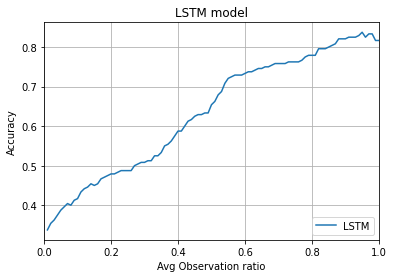

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ratios,acc, label='LSTM')
plt.grid(True)
plt.xlabel('Avg Observation ratio')
plt.ylabel('Accuracy')
plt.title('LSTM model')
plt.xlim(0,1)
plt.legend(loc=4)
plt.show()
